<h1><center>Bayesian Computation project, Spring 2019</center></h1>
<center>Charles Dufour, Sciper: 257587</center>


In [1]:
#to make life easier
%load_ext autoreload
%autoreload 2

In [2]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings

import plotly.offline as py
py.init_notebook_mode(connected=False)

<body>
  <p style="color:red";>Due to a scipy latest update, may have to run twice the cell below</p>
</body>


[See issue on the Github](https://github.com/HIPS/autograd/issues/501) for a quick fix

In [3]:
from src.models import Model, Prior, Conditional_model
from src.sampling import Metropolis_Hastings as MH
from src.helpers import samples_exploration,big_plot,reset_plot, compare_samples_MH,visualisation
from src.optimization import gradient_descent as GD

In [4]:
import src.maths.func_stats as fstats

# Load the data

In [5]:
df = pd.read_csv("data/wages.dat", 
                 sep="\s+")
y_not_normalized = df.LNWAGE.values.copy()

#normalization of continuous variables
df.LNWAGE = (df.LNWAGE - np.mean(df.LNWAGE.values))/np.std(df.LNWAGE.values)
df.ED =(df.ED - np.mean(df.ED.values))/np.std(df.ED.values)
df.EX =(df.EX - np.mean(df.EX.values))/np.std(df.EX.values)

#dropping correlated variables
df = df.drop(columns = ["EXSQ","AGE"], axis = 1)


#building predictors and response matrices
predictors_name = np.array(['ED', 'SOUTH', 'NONWH', 'HISP', 'FE', 'MARR', 'MARRFE', 'EX',
        'UNION', 'MANUF', 'CONSTR', 'MANAG', 'SALES', 'CLER',
        'SERV', 'PROF'])
predictors = df[predictors_name]
y = df.LNWAGE.values
X = predictors.values

#splitting train and test
X, X_test, Y, Y_test,y, y_test = train_test_split(X, y, y_not_normalized, test_size=0.2, random_state=42)

# Exploratory analysis

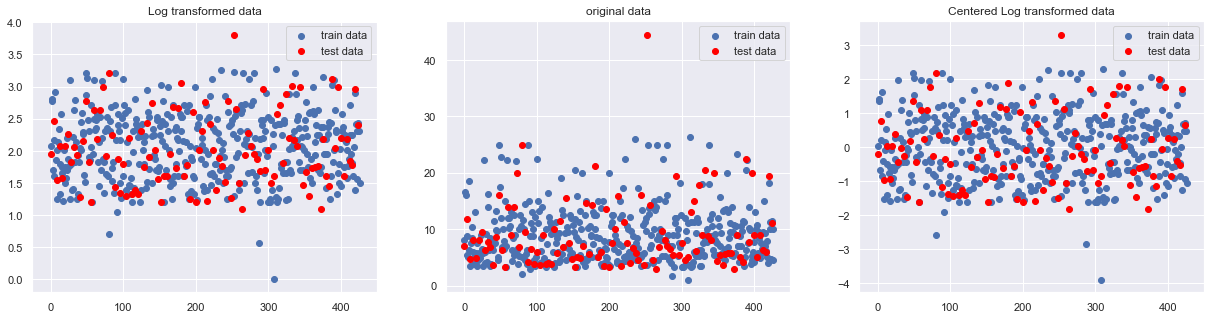

In [6]:
big_plot(21,5)
plt.subplot(132)
plt.scatter(np.arange(len(y)), np.exp(y), label = "train data")
plt.scatter(4*np.arange(len(y_test)), np.exp(y_test), label = "test data", color = "red")
plt.title("original data")
plt.legend()
plt.subplot(131)
plt.scatter(np.arange(len(y)), y, label = "train data")
plt.scatter(4*np.arange(len(y_test)), y_test, label = "test data", color = "red")
plt.title("Log transformed data")
plt.legend()
plt.subplot(133)
plt.scatter(np.arange(len(Y)), Y, label = "train data")
plt.scatter(4*np.arange(len(Y_test)), Y_test, label = "test data", color = "red")
plt.title("Centered Log transformed data")
plt.legend()
plt.show()

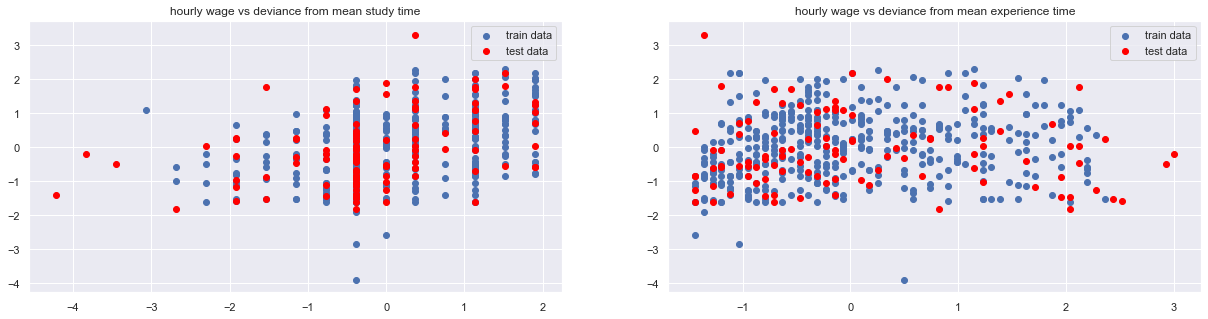

In [7]:
plt.subplot(121)
plt.scatter(X[:,0],Y,label = "train data")
plt.scatter(X_test[:,0],Y_test, label = "test data", color = "red")
plt.legend()
plt.title("hourly wage vs deviance from mean study time")
plt.subplot(122)
plt.scatter(X[:,7],Y, label = "train data")
plt.scatter(X_test[:,7],Y_test, label = "test data", color = "red")
plt.legend()
plt.title("hourly wage vs deviance from mean experience time")
plt.savefig("regressors.png",dpi = 300, bbox_inches = "tight")
plt.show()

# Create the models

`model_gausian`:

- Conditional model:
$$ Y = X\beta + \epsilon$$
$$\varepsilon_i \sim \mathcal{N}(0,\sigma^2)$$

- Priors:
$$\beta \sim \mathcal{N}(\vec{0},3^2I_d)$$
$$\sigma \sim exp(\lambda) \quad \lambda = 2 $$


`model_student`:
    
- conditional model:
$$ Y = X\beta + \epsilon$$


$$\varepsilon_i \sim \text{ Student of degree d }$$


- priors
$$\beta \sim \mathcal{N}(\vec{0},3^2I_d)$$


$$\text{ d } \sim \Gamma(2,4) $$    

In [8]:
model_gaussian = Model.Model(Prior.Gaussian_exp_prior,Conditional_model.Gaussian, Prior = [0,3,2], data = X, response = Y, additional_param = 1)
model_student = Model.Model(Prior.Gaussian_gamma_prior, Conditional_model.Student, Prior = [0,3,2,1/4], data = X, response = Y, additional_param = 1)

# Obtaining estimates

## using MAP

#### using vanilla gradient descent

In [9]:
GD.vanilla_gd(model_gaussian, max_iter= 8000)
GD.vanilla_gd(model_student, max_iter= 8000)

Progress : [====================] 100% Done...
   duration: 0:00:12
Progress : [====================] 100% Done...
   duration: 0:00:16


#### using line search

In [10]:
GD.line_search_gd(model_gaussian, lambda_ = 1e-3,x0 = np.ones(model_gaussian.size),max_iter = 8000)

Progress : [====================] 100% Done...
 converged early at iteration 797  duration: 0:00:02


In [11]:
GD.line_search_gd(model_student, lambda_ = 1e-2,x0 = np.ones(model_student.size),max_iter = 8000)

Progress : [====================] 100% Done...
   duration: 0:00:24


#### using Wolfe condition to adpat the step size

In [12]:
GD.Wolfe_cond_gd(model_gaussian, max_iter = 4000, c1 = 1e-1, initial= 0.5*np.ones(model_gaussian.size))

Progress : [====================] 100% Done...
   duration: 0:00:27


In [13]:
GD.Wolfe_cond_gd(model_student, max_iter = 4000, c1 = 1e-1, initial= 0.5*np.ones(model_student.size))

Progress : [====================] 100% Done...
   duration: 0:00:39


## Using Metropolis Hastings

#### with gaussian random walk

Progress : [====================] 100% Done...
  Acceptance rate : 16.2%  (advised values between 10% and 50%)
  duration: 0:00:12
iterations


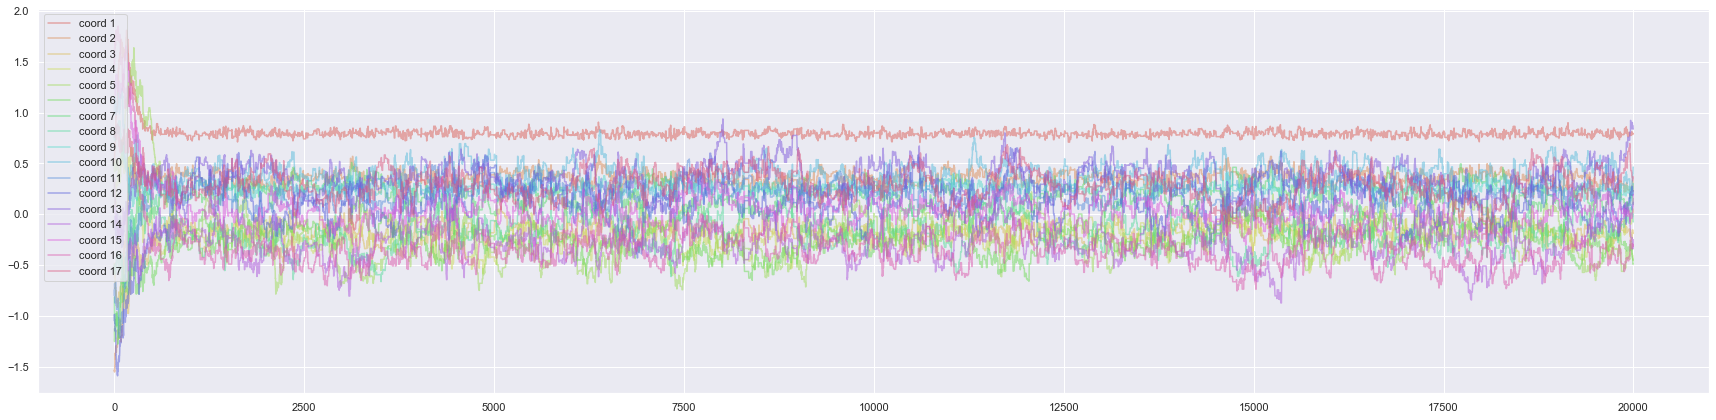

In [14]:
with warnings.catch_warnings(record=True):
    initial = np.random.randn(model_gaussian.size)
    initial[0]=0.5
    step_size = 0.05*np.ones(model_gaussian.size)
    step_size[0]=0.035
    samples_gaussian_rw = MH.random_walk_MH(model_gaussian, max_iter = 20000, verbose = True, step_size = step_size, initial = initial, RETURN= True)
    samples_exploration(samples_gaussian_rw,correlation=False,distribution=False)

Progress : [====================] 100% Done...
  Acceptance rate : 37.4%  (advised values between 10% and 50%)
  duration: 0:00:14
iterations


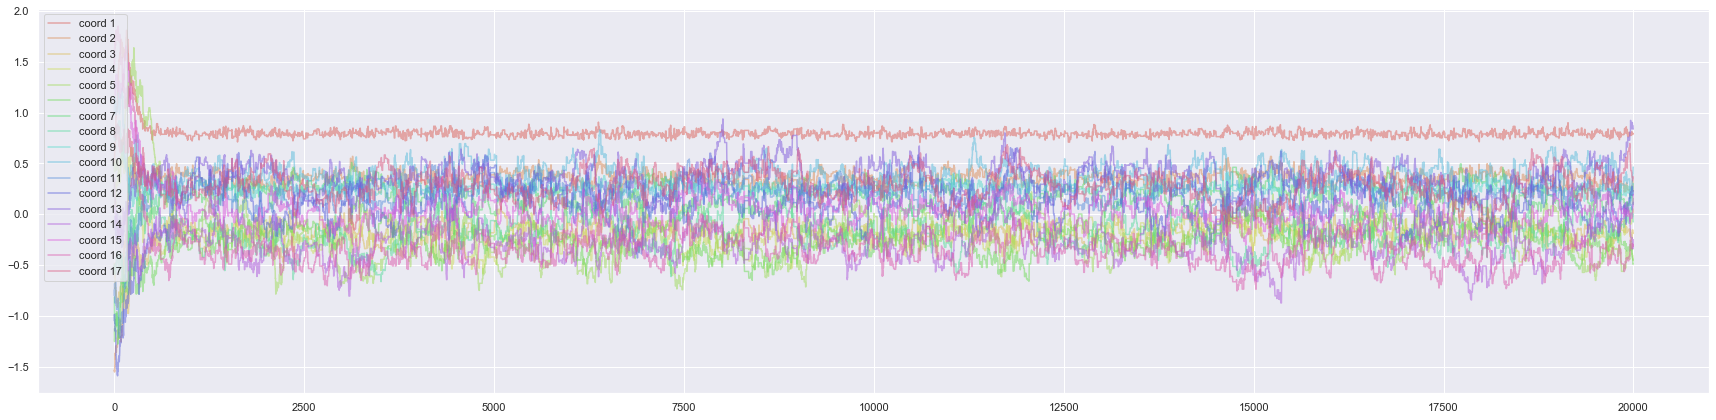

In [15]:
with warnings.catch_warnings(record=True):
    initial = np.random.randn(model_student.size)
    initial[0]= 20
    step_size = np.ones_like(initial)*0.035
    step_size[0] = 5
    samples_student_rw = MH.random_walk_MH(model_student, max_iter = 20000, verbose = True, step_size = step_size, initial = initial,RETURN= True)
    samples_exploration(samples_gaussian_rw,correlation=False,distribution=False)

#### with Langevin correction

Progress : [====================] 100% Done...
  Acceptance rate : 58.6%  (advised values between 10% and 50%)
  duration: 0:01:37
iterations


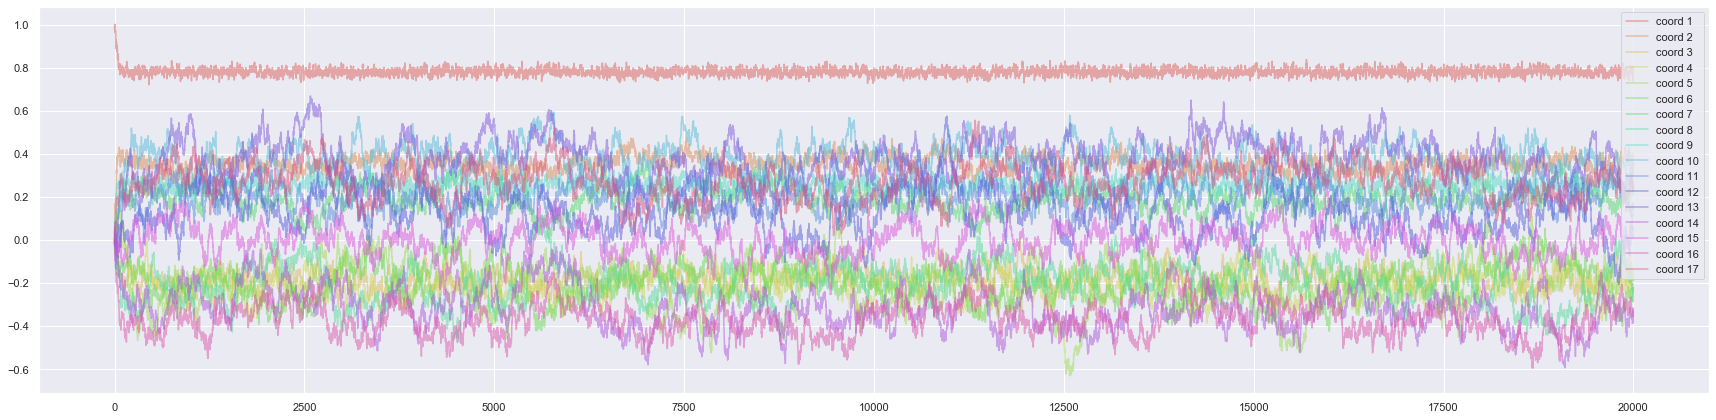

In [16]:
with warnings.catch_warnings(record=True):
    initial = np.zeros(model_gaussian.size)
    initial[0]=1
    samples_gaussian_langevin = MH.Langevin_MH(model_gaussian, max_iter = 20000, initial = initial,verbose = True, tau = 1e-4,RETURN=True)
    samples_exploration(samples_gaussian_langevin,correlation=False,distribution=False)

Progress : [====================] 100% Done...
  Acceptance rate : 26.0%  (advised values between 10% and 50%)
  duration: 0:02:12
iterations


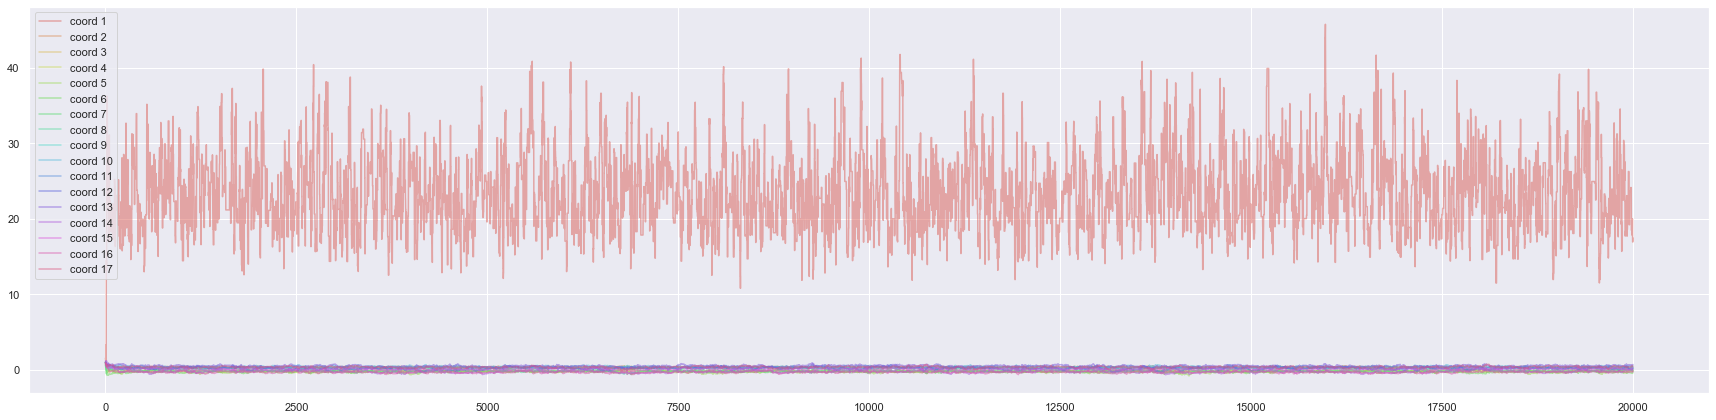

In [17]:
with warnings.catch_warnings(record=True):
    initial = np.ones(model_student.size)
    initial[0]=12
    step_size = np.ones(model_student.size)
    step_size[0] = 100
    samples_student_langevin = MH.Langevin_MH(model_student, max_iter = 20000, initial = initial, tau = 1e-3, RETURN=True,step_size = step_size)
    samples_exploration(samples_student_langevin,correlation=False, distribution = False)

#### comparison of the metropolis hastings chains

gaussian model

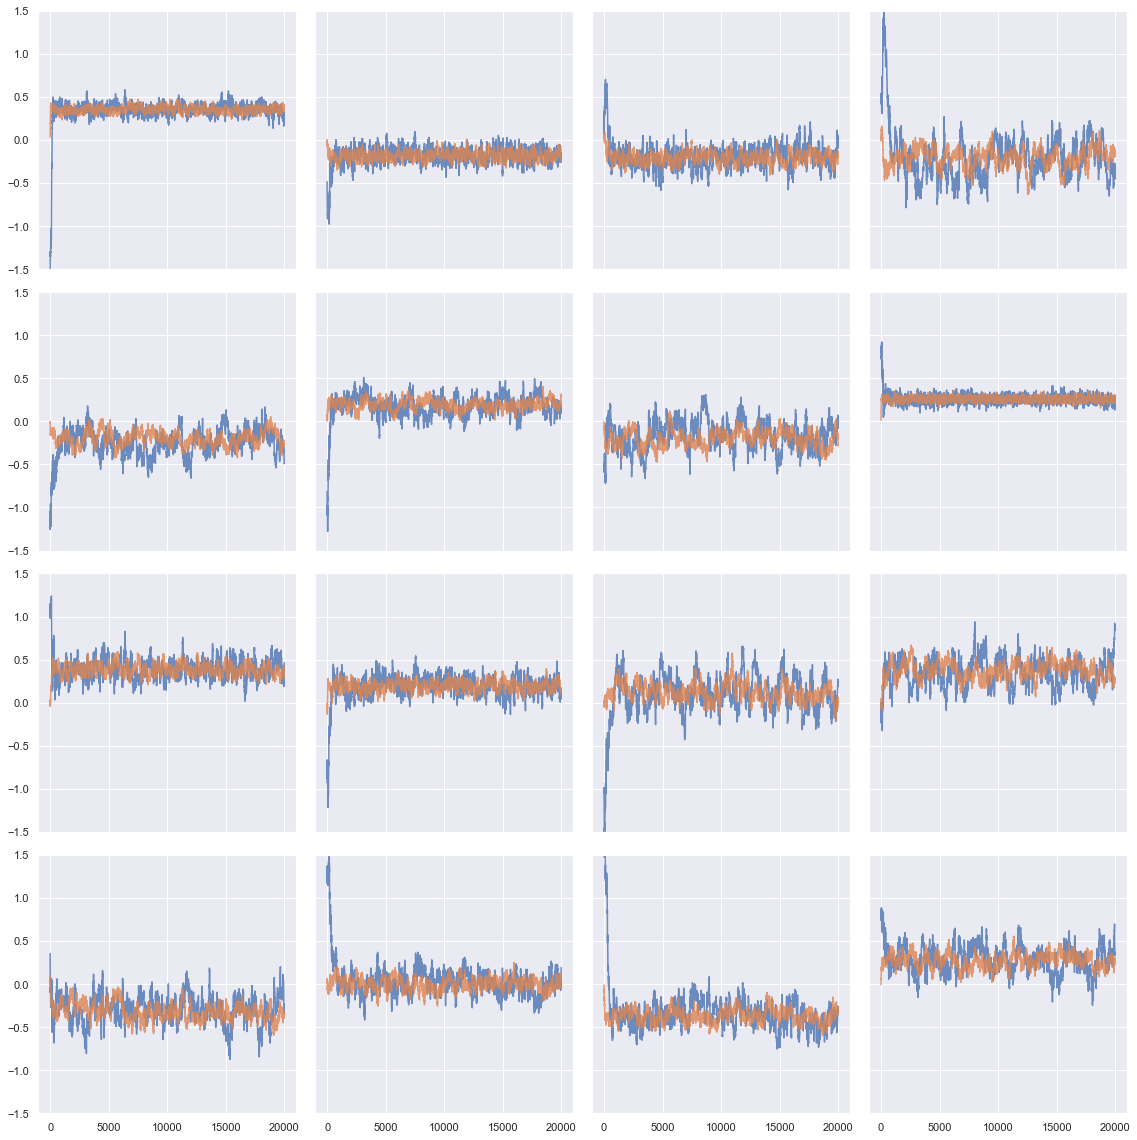

In [18]:
compare_samples_MH(samples_gaussian_rw,samples_gaussian_langevin)

student model

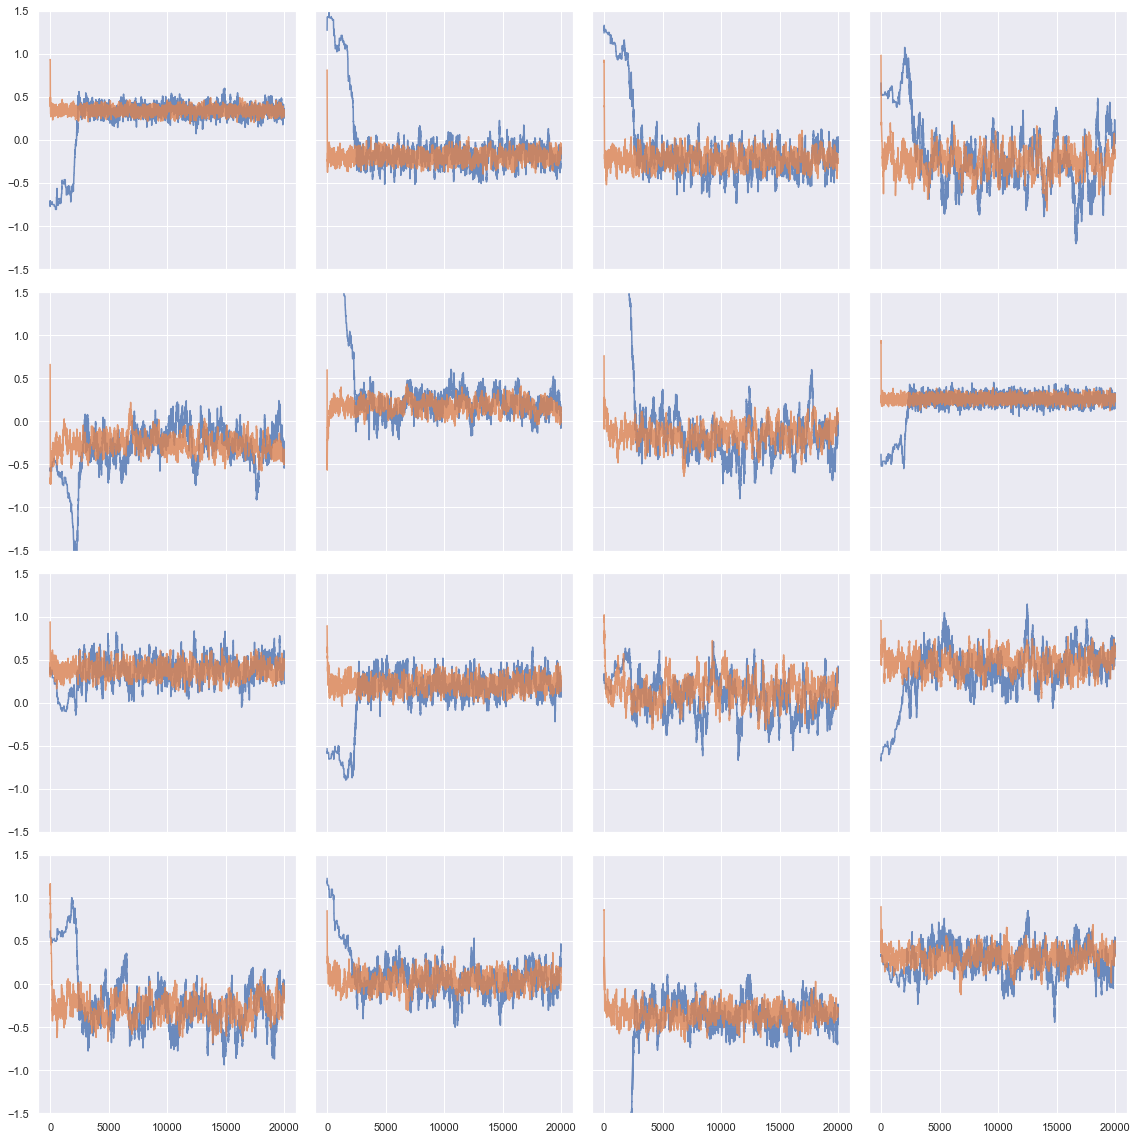

In [19]:
compare_samples_MH(samples_student_rw,samples_student_langevin)

### extraction of the estimates from the models

In [20]:
r_gaussian = model_gaussian()
r_gaussian.T

error         ED     SOUTH     NONWH      HISP  \
gd                  0.773617  0.351707 -0.185607 -0.204573 -0.212707   
line_search_gd      0.773617  0.351707 -0.185607 -0.204573 -0.212708   
Wolfe_cond_gd       0.937500  0.467542  0.014844  0.226920  0.410712   
MH_vanilla_mean     0.792479  0.357564 -0.171866 -0.203778 -0.245315   
MH_vanilla_median   0.790394  0.357613 -0.170977 -0.201432 -0.241757   
MH_Langevin_mean    0.780039  0.354400 -0.183615 -0.208836 -0.208887   
MH_Langevin_median  0.779755  0.353790 -0.185013 -0.208313 -0.198475   

                          FE      MARR    MARRFE        EX     UNION  \
gd                 -0.239069  0.169969 -0.162222  0.258266  0.385554   
line_search_gd     -0.239071  0.169967 -0.162219  0.258266  0.385554   
Wolfe_cond_gd      -0.229593 -0.202774 -0.022500  0.332110  0.352425   
MH_vanilla_mean    -0.237586  0.183387 -0.161679  0.257536  0.393403   
MH_vanilla_median  -0.232492  0.185610 -0.162058  0.256354  0.390009   
MH_Langevin_mean   -0.200972  0.192557 -0.198393  0.259144  0.385886   
MH_Langevin_median -0.202280  0.192240 -0.193432  0.259188  0.380989   

                       MANUF    CONSTR     MANAG     SALES      CLER  \
gd                  0.212763  0.141788  0.393541 -0.297683  0.025753   
line_search_gd      0.212764  0.141789  0.393543 -0.297681  0.025755   
Wolfe_cond_gd       0.328985  0.457122  0.419534  0.369744  0.224076   
MH_vanilla_mean     0.203313  0.116880  0.345978 -0.297423  0.009798   
MH_vanilla_median   0.207401  0.106713  0.350375 -0.296713  0.012834   
MH_Langevin_mean    0.192980  0.117720  0.378778 -0.324937 -0.004412   
MH_Langevin_median  0.194238  0.112929  0.379072 -0.330864 -0.005680   

                        SERV      PROF  
gd                 -0.345084  0.297531  
line_search_gd     -0.345082  0.297534  
Wolfe_cond_gd       0.208475  0.328472  
MH_vanilla_mean    -0.364800  0.277600  
MH_vanilla_median  -0.366837  0.274698  
MH_Langevin_mean   -0.366980  0.268732  
MH_Langevin_median -0.368963  0.271030

In [21]:
r_student = model_student()
r_student.T

error         ED     SOUTH     NONWH      HISP  \
gd                   6.721010  0.339488 -0.204337 -0.240525 -0.296978   
line_search_gd      18.744119  0.341741 -0.197535 -0.220067 -0.256264   
Wolfe_cond_gd        6.339830  0.339387 -0.204712 -0.242420 -0.299998   
MH_vanilla_mean     24.318309  0.334194 -0.171693 -0.213878 -0.245821   
MH_vanilla_median   22.966163  0.339656 -0.177401 -0.232103 -0.266683   
MH_Langevin_mean    23.485339  0.342491 -0.192226 -0.214063 -0.257912   
MH_Langevin_median  22.865452  0.342308 -0.192950 -0.211141 -0.256394   

                          FE      MARR    MARRFE        EX     UNION  \
gd                 -0.265006  0.207225 -0.188031  0.264382  0.365790   
line_search_gd     -0.251051  0.190463 -0.178088  0.260819  0.373601   
Wolfe_cond_gd      -0.267034  0.207635 -0.187642  0.264635  0.365522   
MH_vanilla_mean    -0.270528  0.210174 -0.152198  0.254205  0.386697   
MH_vanilla_median  -0.241042  0.206634 -0.201858  0.257908  0.390419   
MH_Langevin_mean   -0.260297  0.178479 -0.159263  0.261814  0.379564   
MH_Langevin_median -0.264794  0.178892 -0.156497  0.261913  0.377405   

                       MANUF    CONSTR     MANAG     SALES      CLER  \
gd                  0.205155  0.122407  0.503294 -0.280685  0.059388   
line_search_gd      0.206468  0.129351  0.461792 -0.290331  0.042638   
Wolfe_cond_gd       0.205477  0.122620  0.506597 -0.278924  0.061327   
MH_vanilla_mean     0.192410  0.040161  0.432214 -0.287860  0.035433   
MH_vanilla_median   0.201261  0.045945  0.425859 -0.303934  0.035735   
MH_Langevin_mean    0.210339  0.133353  0.454900 -0.284266  0.039990   
MH_Langevin_median  0.212029  0.128225  0.457663 -0.282640  0.041149   

                        SERV      PROF  
gd                 -0.359586  0.312890  
line_search_gd     -0.351271  0.308540  
Wolfe_cond_gd      -0.359544  0.313935  
MH_vanilla_mean    -0.399283  0.290026  
MH_vanilla_median  -0.376161  0.299730  
MH_Langevin_mean   -0.348894  0.312264  
MH_Langevin_median -0.347645  0.314808

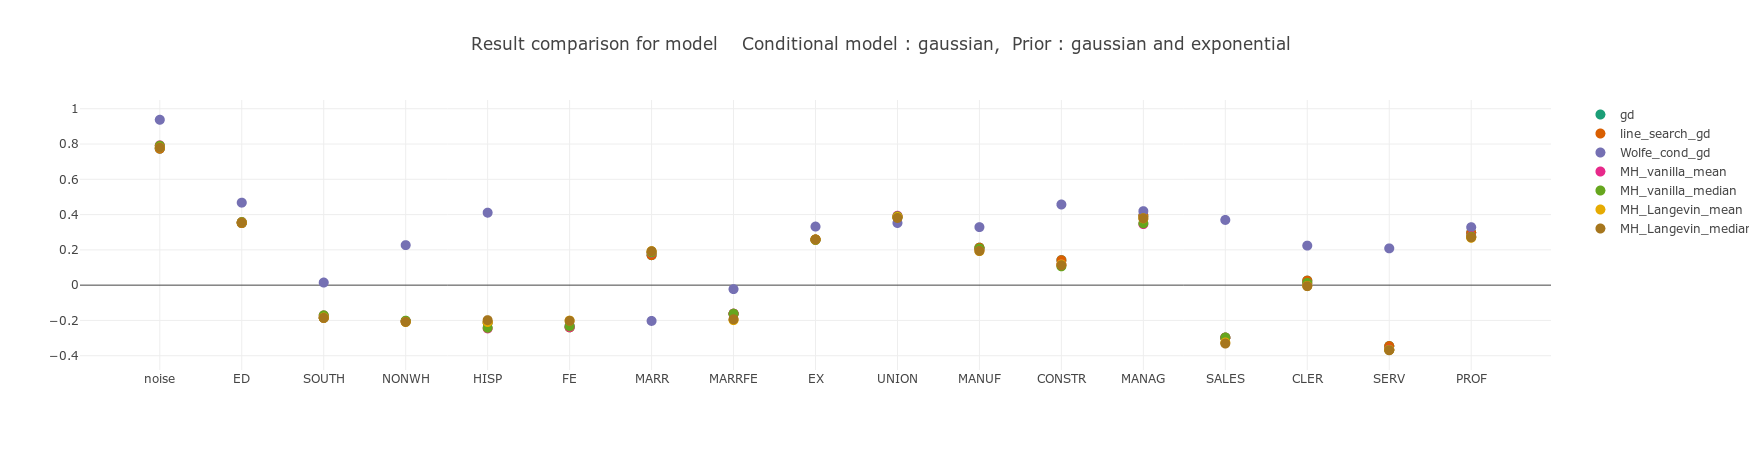

In [22]:
visualisation(r_gaussian,model_gaussian)

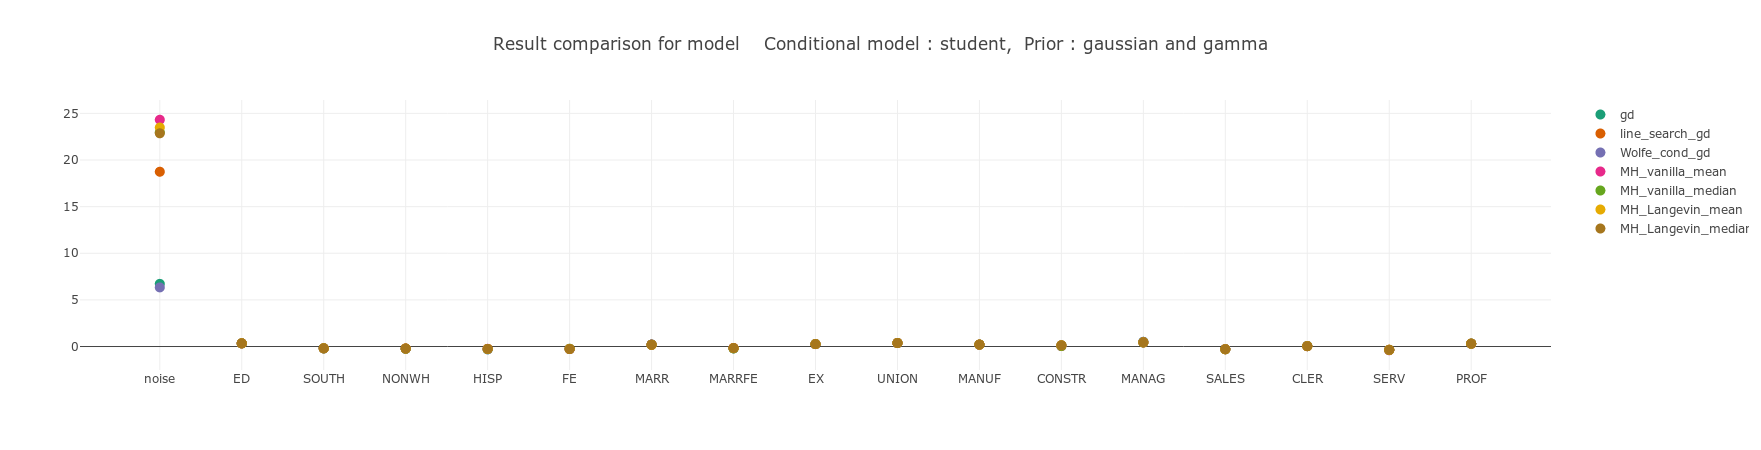

In [23]:
visualisation(r_student,model_student)

## Accuracy of the prediction

In [41]:
errors_student = pd.DataFrame()
for name in r_student.columns:
    beta = r_student[name].values[1:]
    errors_student[name] = [np.sum(np.abs(Y_test-np.dot(X_test,beta)))/len(Y_test),np.sum(np.abs(Y-np.dot(X,beta)))/len(Y)]
errors_student.index = ["error on test","error on train"]
errors_student.T

error on test  error on train
gd                       0.685292        0.609907
line_search_gd           0.685159        0.611209
Wolfe_cond_gd            0.685284        0.609814
MH_vanilla_mean          0.687430        0.611630
MH_vanilla_median        0.685471        0.612177
MH_Langevin_mean         0.685110        0.611450
MH_Langevin_median       0.684638        0.611450

In [42]:
errors_gaussian = pd.DataFrame()
for name in r_gaussian.columns:
    beta = r_gaussian[name].values[1:]
    errors_gaussian[name] = [np.sum(np.abs(Y_test-np.dot(X_test,beta)))/len(Y_test),np.sum(np.abs(Y-np.dot(X,beta)))/len(Y)]
errors_gaussian.index = ["error on test","error on train"]
errors_gaussian.T

error on test  error on train
gd                       0.685706        0.613765
line_search_gd           0.685706        0.613765
Wolfe_cond_gd            0.738525        0.692682
MH_vanilla_mean          0.687246        0.614395
MH_vanilla_median        0.688279        0.614266
MH_Langevin_mean         0.687873        0.613893
MH_Langevin_median       0.688071        0.614006

# Classification 

`multilogi`:

- Conditional model
$$\mathbb{P}\left(Y=1|X\right) = \frac{e^{X^T\beta}}{1+e^{X^T\beta}}$$

- Prior:
$$\beta \sim N(0,3^2I) $$

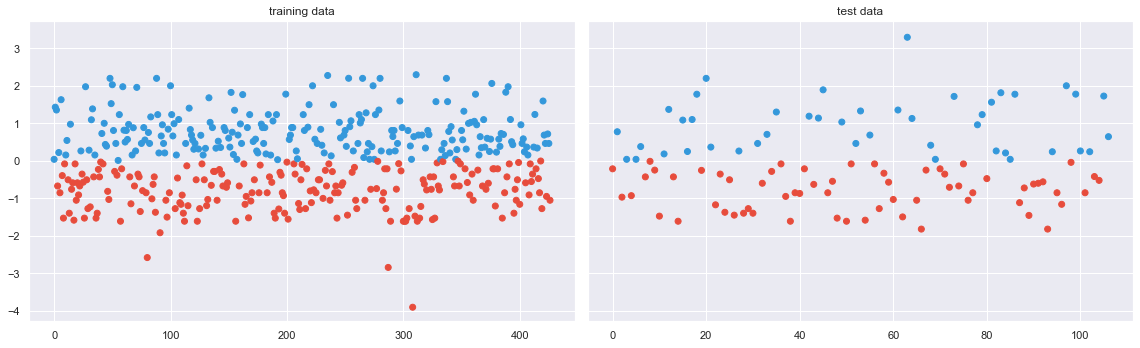

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

inter = Y
classes = inter.copy()
classes[Y >= 0] = 0
classes[Y < 0 ]= 1

#flatui = ["#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
flatui = ["#3498db", "#e74c3c", "#34495e", "#2ecc71"]

def convert(n): 
    return flatui[int(n)]
colors = list(map(convert, classes) )

axs[0].scatter(np.arange(0,X.shape[0]),Y, c = colors)
axs[0].set_title("training data")


inter = Y_test
classes_test = inter.copy()
classes_test[Y_test >= 0] = 0
classes_test[Y_test < 0 ]= 1
colors = list(map(convert, classes_test) )


axs[1].scatter(np.arange(0,X_test.shape[0]),Y_test, c = colors)
axs[1].set_title("test data")

plt.tight_layout()
plt.show()

In [60]:
multilogi = Model.Model(Prior.Gaussian_prior,Conditional_model.Multilogistic,data = X,response = classes, Prior = [0,3*np.ones(16)],cond_model = [2])

In [61]:
GD.vanilla_gd(multilogi, max_iter= 8000)

Progress : [====================] 100% Done...
   duration: 0:00:05


In [62]:
GD.line_search_gd(multilogi, lambda_ = 1e-3,x0 = np.ones(multilogi.size),max_iter = 8000)

Progress : [====================] 100% Done...
 converged early at iteration 5606  duration: 0:00:05


In [63]:
GD.Wolfe_cond_gd(multilogi, max_iter = 4000, c1 = 1e-1, initial= 0.5*np.ones(multilogi.size))

Progress : [====================] 100% Done...
   duration: 0:00:08


Progress : [====================] 100% Done...
  Acceptance rate : 38.6%  (advised values between 10% and 50%)
  duration: 0:00:17
iterations


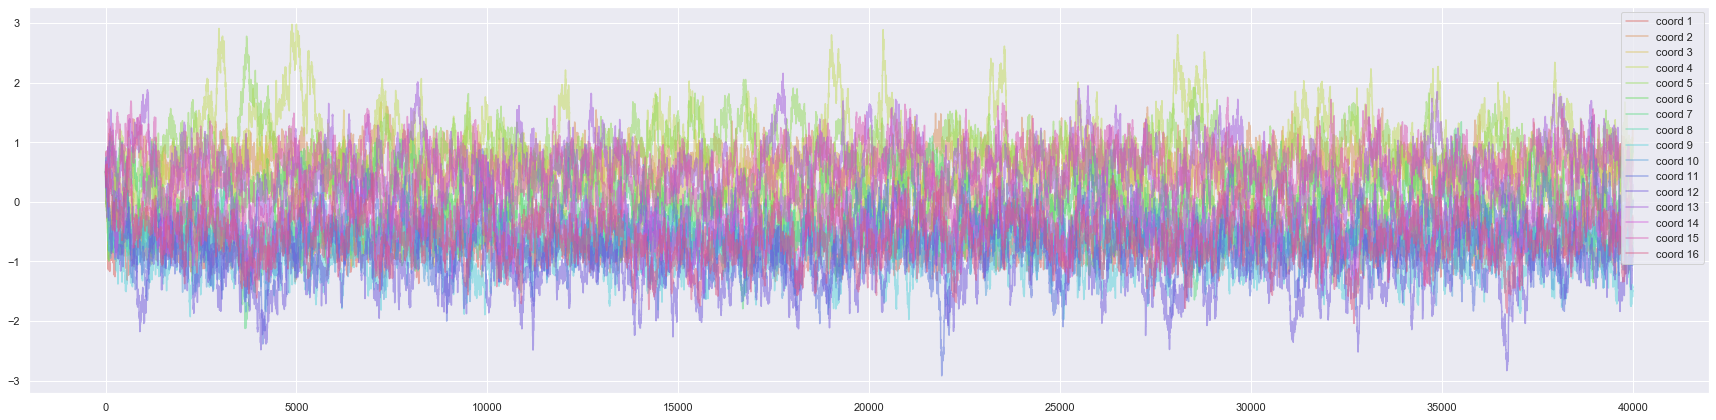

In [64]:
with warnings.catch_warnings(record = True):
    initial = np.zeros(multilogi.size) + 0.5
    samples_classification_rw = MH.random_walk_MH(multilogi, max_iter = 40000, verbose = True, step_size = 1e-1, initial = initial, RETURN=True)
    samples_exploration(samples_classification_rw, distribution=False, correlation= False)

Progress : [====================] 100% Done...
  Acceptance rate : 18.0%  (advised values between 10% and 50%)
  duration: 0:00:57
iterations


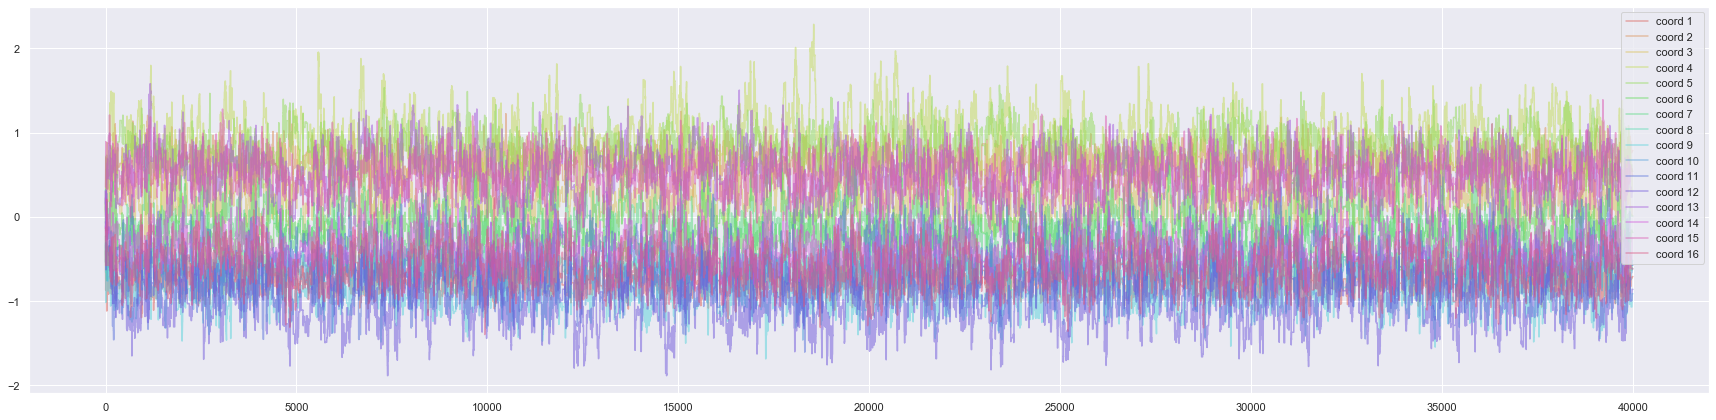

In [65]:
with warnings.catch_warnings(record = True):
    initial = np.zeros(multilogi.size) + 0.1
    samples_classification_langevin = MH.Langevin_MH(multilogi, max_iter = 40000, verbose = True, initial = initial, tau = 1e-2,RETURN=True)
    samples_exploration(samples_classification_langevin, distribution=False, correlation= False)

In [66]:
r_multilogi = multilogi()
r_multilogi.T

ED     SOUTH     NONWH      HISP        FE  \
gd                 -0.756271  0.634856  0.178275  0.725647  0.655969   
line_search_gd     -0.745740  0.637126  0.198143  0.750089  0.749299   
Wolfe_cond_gd      -0.745817  0.637126  0.198003  0.749741  0.748650   
MH_vanilla_mean    -0.774053  0.689232  0.202842  0.786302  0.747883   
MH_vanilla_median  -0.771100  0.685185  0.199920  0.765619  0.729606   
MH_Langevin_mean   -0.758325  0.652036  0.209623  0.837733  0.790966   
MH_Langevin_median -0.755536  0.649591  0.208126  0.840447  0.791268   

                        MARR    MARRFE        EX     UNION     MANUF  \
gd                 -0.335100 -0.002249 -0.566482 -0.861472 -0.609740   
line_search_gd     -0.276186 -0.094773 -0.566730 -0.871967 -0.642510   
Wolfe_cond_gd      -0.276601 -0.094112 -0.566733 -0.871869 -0.642297   
MH_vanilla_mean    -0.285910 -0.034613 -0.593470 -0.928801 -0.668878   
MH_vanilla_median  -0.292712 -0.029229 -0.592639 -0.935165 -0.658071   
MH_Langevin_mean   -0.261783 -0.116521 -0.577685 -0.891895 -0.668368   
MH_Langevin_median -0.260345 -0.104047 -0.575206 -0.889230 -0.664155   

                      CONSTR     MANAG     SALES      CLER      SERV      PROF  
gd                 -0.428434 -0.880174  0.578037 -0.279040  0.586276 -0.485030  
line_search_gd     -0.481143 -0.962650  0.510775 -0.344109  0.521019 -0.564106  
Wolfe_cond_gd      -0.480883 -0.962098  0.511308 -0.343662  0.521453 -0.563554  
MH_vanilla_mean    -0.535333 -1.050003  0.536496 -0.379039  0.547963 -0.614133  
MH_vanilla_median  -0.514211 -1.053724  0.535121 -0.365559  0.554939 -0.608312  
MH_Langevin_mean   -0.530757 -1.014106  0.500691 -0.384057  0.500618 -0.608298  
MH_Langevin_median -0.528749 -1.007211  0.495977 -0.388385  0.498138 -0.609503

## Results of logistic regression

In [67]:
predictions = multilogi.predict(X_test)
fitted = multilogi.predict(X)

In [68]:
errors = {}

In [69]:
for name in predictions.columns:
    error = 0
    for pred,true in zip(predictions[name],classes_test):
        if pred != true:
            error+=1    
    if name in errors.keys():
        errors[name].append(error/len(classes_test))
    else:
        errors[name] = [error/len(classes_test)]

In [70]:
for name in predictions.columns:
    error = 0
    for pred,true in zip(predictions[name],classes):
        if pred != true:
            error+=1    
    if name in errors.keys():
        errors[name].append(error/len(classes))
    else:
        errors[name] = [error/len(classes)]

In [71]:
errors = pd.DataFrame(errors)
errors.index = ["error on test", "error on train"]
errors.T

error on test  error on train
gd                       0.448598        0.271663
line_search_gd           0.467290        0.269321
Wolfe_cond_gd            0.467290        0.269321
MH_vanilla_mean          0.467290        0.274005
MH_vanilla_median        0.467290        0.271663
MH_Langevin_mean         0.467290        0.271663
MH_Langevin_median       0.467290        0.274005

In [73]:
df_time = pd.DataFrame()
df_time["gradient descent"] = [12,16,5]
df_time["line search (early stopping)"]=[2,24,5]
df_time["Wolfe condition"] = [27,39,8]
df_time["Metropolis Hastings random walk"] = [12,14,17]
df_time["Metropolis Hastings Langevin"] = [97,192,56]
df_time.index = ["Gaussian model","Student model","Logistic model"]
df_time

gradient descent  line search (early stopping)  \
Gaussian model                12                             2   
Student model                 16                            24   
Logistic model                 5                             5   

                Wolfe condition  Metropolis Hastings random walk  \
Gaussian model               27                               12   
Student model                39                               14   
Logistic model                8                               17   

                Metropolis Hastings Langevin  
Gaussian model                            97  
Student model                            192  
Logistic model                            56

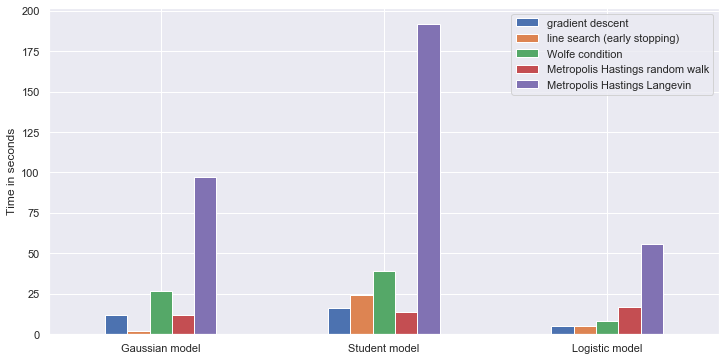

In [85]:
big_plot(12,6)
df_time.plot(kind='bar')
labels = df.index
plt.xticks(rotation='horizontal')
plt.ylabel("Time in seconds")
plt.savefig("time.png",dvi = 300)
plt.show()